<a href="https://colab.research.google.com/github/ArpitaChatterjee/Mobile-and-Ubiquitous-Computing-Assignment-/blob/main/SensorDataAnalysisActivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. SETUP & HELPER FUNCTIONS

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os



DATA_DIR = 'data' # Ensure your CSV files are in a folder named 'data'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

def load_data(filename):
    """Parses CSV data into a clean DataFrame."""
    path = os.path.join(DATA_DIR, filename)
    if not os.path.exists(path):
        print(f"[Warning] File not found: {filename}")
        return None

    df = pd.read_csv(path)

    # Normalize column names from Phyphox
    rename_map = {}
    for col in df.columns:
        c_lower = col.lower()
        if 'time' in c_lower: rename_map[col] = 'time'
        elif 'x (' in c_lower: rename_map[col] = 'x'
        elif 'y (' in c_lower: rename_map[col] = 'y'
        elif 'z (' in c_lower: rename_map[col] = 'z'
        elif 'absolute' in c_lower: rename_map[col] = 'abs'

    df.rename(columns=rename_map, inplace=True)
    return df

def vector_magnitude(df):
    """Calculates Euclidean norm (Orientation Invariant)."""
    # Prefer calculating from raw axes to ensure consistency
    if 'x' in df.columns and 'y' in df.columns:
        return np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    elif 'abs' in df.columns:
        return df['abs'].values
    return np.zeros(len(df))

def moving_average(data_array, window_size):
    """Low-pass filter to smooth sensor noise."""
    return pd.Series(data_array).rolling(window=window_size, center=True).mean().fillna(0).values

def clean_data(df):
    """Removes first 3s and last 3s (Standing Still)."""
    if df is None: return None
    t_min = df['time'].min()
    t_max = df['time'].max()
    mask = (df['time'] >= t_min + 3.0) & (df['time'] <= t_max - 3.0)
    cleaned = df.loc[mask].copy()
    cleaned['time'] = cleaned['time'] - cleaned['time'].iloc[0] # Reset time
    return cleaned


# 2. TASK EXECUTION FUNCTIONS


## Task1 : Sampling Rate Analysis

In [16]:

def task1_sampling_rate(df, name):
    print(f"\n--- Task 1: Sampling Rate ({name}) ---")
    time_diffs = np.diff(df['time'])
    avg_diff = np.mean(time_diffs)
    sampling_rate = 1.0 / avg_diff
    jitter = np.std(time_diffs)

    print(f"Sampling Rate: {sampling_rate:.2f} Hz")
    print(f"Jitter (Stability): {jitter:.6f} s")
    return sampling_rate



##  Task 2: Data Cleaning

In [17]:
def task2_plot_and_clean(df, name):
    print(f"\n--- Task 2: Cleaning ({name}) ---")
    # Plot Raw
    plt.figure(figsize=(10, 4))
    plt.plot(df['time'], df['x'], label='X')
    plt.plot(df['time'], df['y'], label='Y')
    plt.plot(df['time'], df['z'], label='Z')
    plt.title(f"Raw Data: {name}")
    plt.legend()
    plt.show()

    # Clean
    df_clean = clean_data(df)

    # Plot Clean
    plt.figure(figsize=(10, 4))
    plt.plot(df_clean['time'], df_clean['x'], label='X')
    plt.plot(df_clean['time'], df_clean['y'], label='Y')
    plt.plot(df_clean['time'], df_clean['z'], label='Z')
    plt.title(f"Cleaned Data: {name}")
    plt.legend()
    plt.show()

    return df_clean


## Task 3: Step Counts (Walk)

In [18]:
def task3_count_steps(df, name, threshold=10.5):
    print(f"\n--- Task 3: Counting Steps ({name}) ---")

    # 1. Magnitude
    mag = vector_magnitude(df)

    # 2. Moving Average
    smooth_mag = moving_average(mag, window_size=10)

    # 3. Peak Detection
    # height: Gravity is 9.8, step impacts usually > 10.5
    # distance: Minimum samples between steps (human cadence limit)
    peaks, _ = find_peaks(smooth_mag, height=threshold, distance=15)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(df['time'], smooth_mag, label='Smoothed Magnitude', color='green')
    plt.plot(df['time'].iloc[peaks], smooth_mag[peaks], "x", color='red', label='Steps')
    plt.axhline(y=threshold, color='orange', linestyle='--', label='Threshold')
    plt.title(f"Step Count for {name}: {len(peaks)}")
    plt.legend()
    plt.show()

    print(f"Steps Counted: {len(peaks)}")
    return len(peaks)


## Task 4: Step Counts (Climb)

In [19]:
def task4_climbing_segmentation(df):
    print(f"\n--- Task 4: Climbing Segmentation ---")

    mag = vector_magnitude(df)

    # 1. Rolling Energy (Standard Deviation)
    # Window of 100 samples (approx 1 second) captures the variance of motion
    rolling_energy = pd.Series(mag).rolling(window=100).std().fillna(0)

    # 2. Dynamic Thresholding
    # The mean energy of the whole file often acts as a good separator
    threshold = rolling_energy.mean()
    is_climbing = rolling_energy > threshold

    # 3. Filter Data
    climbing_data = df.loc[is_climbing].copy()

    # Plot Segmentation
    plt.figure(figsize=(12, 6))
    plt.plot(df['time'], mag, alpha=0.3, label='Raw Magnitude')
    plt.plot(df['time'], rolling_energy, color='orange', label='Rolling Energy (Std)')
    plt.axhline(y=threshold, color='red', linestyle='--', label='Segmentation Threshold')
    plt.fill_between(df['time'], 0, mag.max(), where=is_climbing,
                     color='green', alpha=0.2, label='Climbing Segment')
    plt.title("Stair Climbing Segmentation")
    plt.legend()
    plt.show()

    # 4. Count Steps in Climbing Segments
    # Climbing impacts are harder, so we use a higher threshold (11.0)
    if len(climbing_data) > 0:
        smooth_climb = moving_average(vector_magnitude(climbing_data), 10)
        peaks, _ = find_peaks(smooth_climb, height=11.0, distance=15)
        print(f"Stairs Climbed: {len(peaks)}")
    else:
        print("No climbing segments detected.")


## Task 5: Bonus (Feature Matching)

In [20]:

def task5_bonus_matching():
    print(f"\n--- Task 5: Bonus Matching ---")

    def get_features(df):
        mag = vector_magnitude(df)
        return np.array([np.mean(mag), np.std(mag), np.max(mag), np.median(mag)])

    # Load Training Data
    train_files = ['window1.csv', 'window2.csv', 'window3.csv']
    # Mapping based on standard assignment keys (Verify if provided differently)
    # Typically: Window 1=Ming, Window 2=Shlok, Window 3=Dylan
    train_labels = ['Ming', 'Shlok', 'Dylan']

    train_feats = []
    for f in train_files:
        df = load_data(f)
        if df is not None:
            train_feats.append(get_features(df))
        else:
            train_feats.append(np.array([0,0,0,0])) # Placeholder

    # Load Test Data
    test_files = ['test_window1.csv', 'test_window2.csv', 'test_window3.csv']

    print(f"{'Test File':<20} | {'Matched TA':<15} | {'Distance':<10}")
    print("-" * 50)

    for tf in test_files:
        df_test = load_data(tf)
        if df_test is None: continue

        feat = get_features(df_test)

        # Euclidean Distance
        dists = [np.linalg.norm(feat - tr_f) for tr_f in train_feats]
        match_idx = np.argmin(dists)

        print(f"{tf:<20} | {train_labels[match_idx]:<15} | {dists[match_idx]:.4f}")



# 3. MAIN RUNNER



--- Task 1: Sampling Rate (Walk 1) ---
Sampling Rate: 100.34 Hz
Jitter (Stability): 0.000001 s

--- Task 2: Cleaning (Walk 1) ---


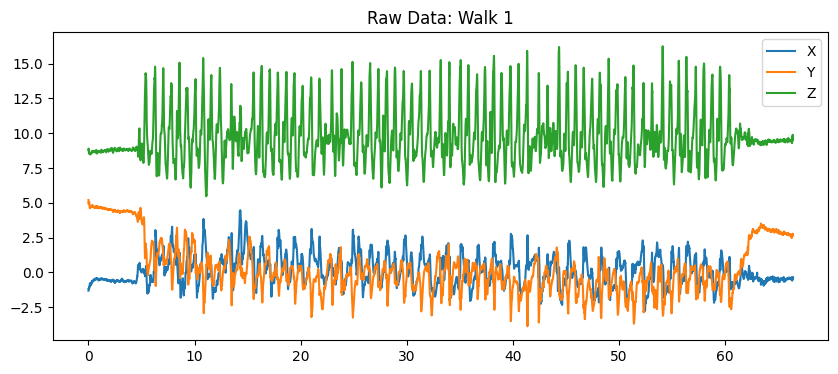

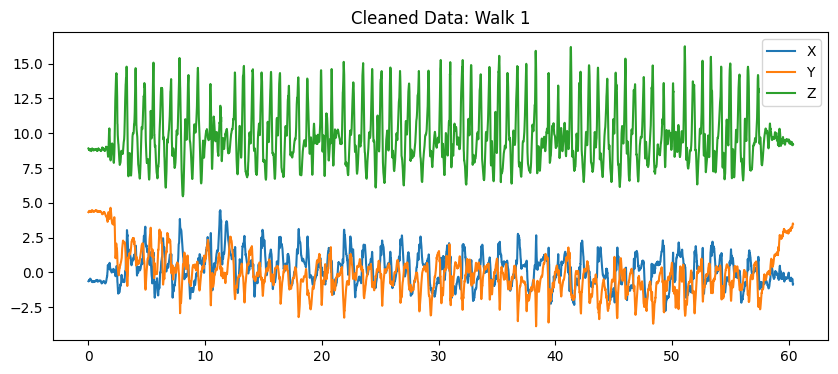


--- Task 3: Counting Steps (Walk 1) ---


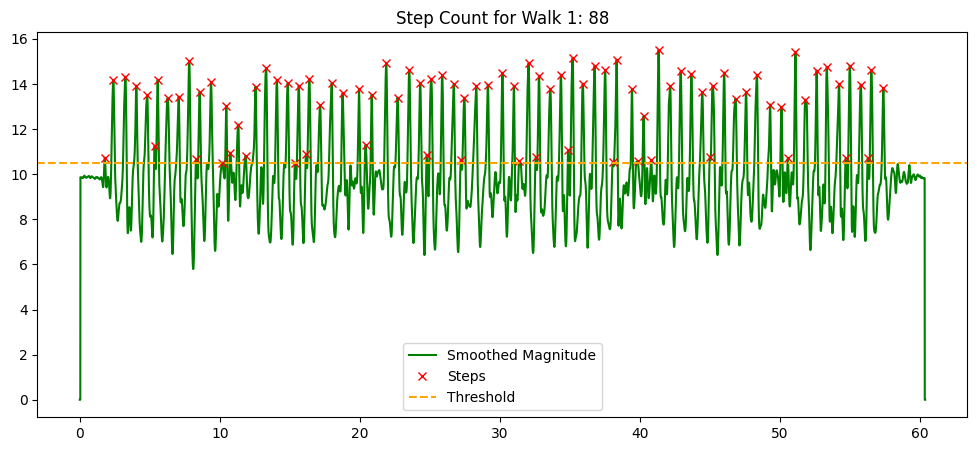

Steps Counted: 88

--- Task 2: Cleaning (Walk 2) ---


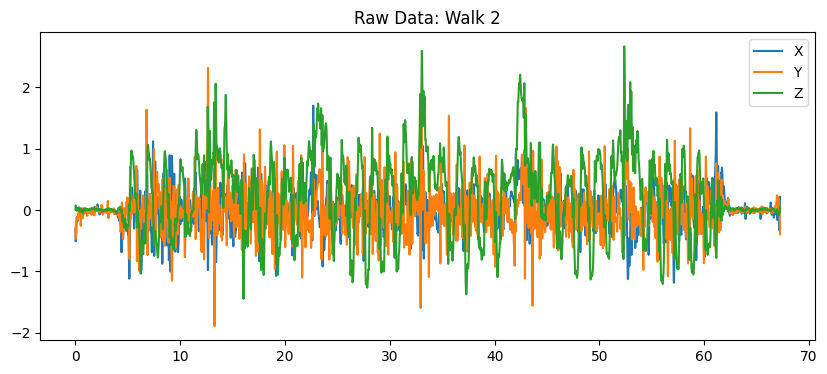

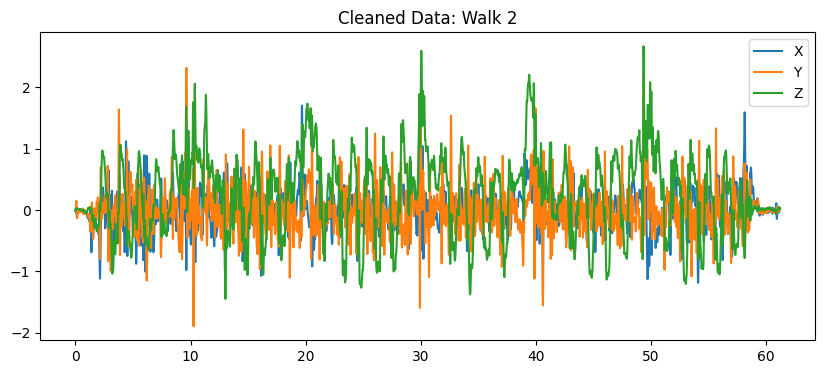


--- Task 3: Counting Steps (Walk 2) ---


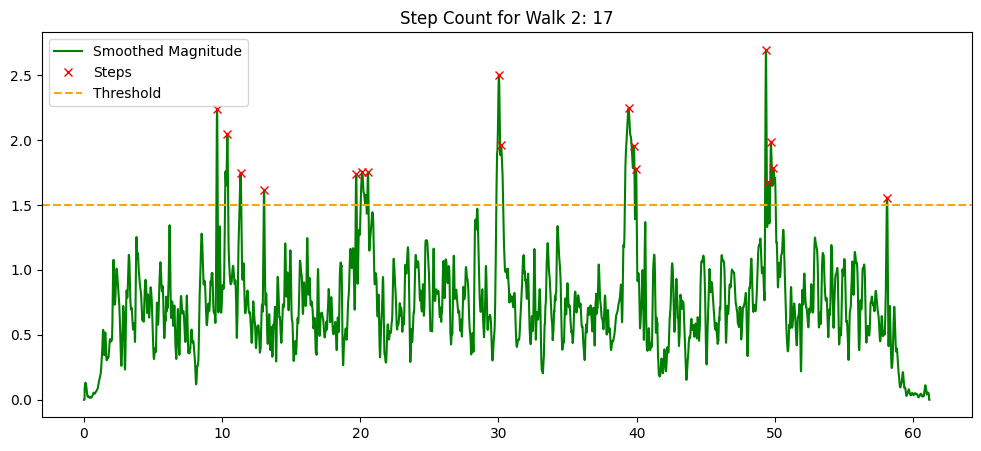

Steps Counted: 17

--- Task 4: Climbing Segmentation ---


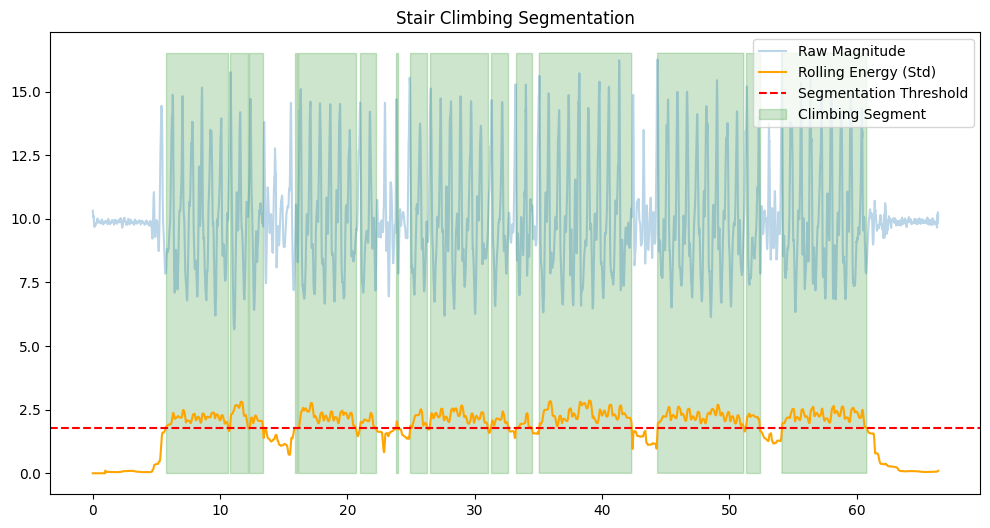

Stairs Climbed: 59

--- Task 5: Bonus Matching ---
Test File            | Matched TA      | Distance  
--------------------------------------------------
test_window1.csv     | Dylan           | 1.7858
test_window2.csv     | Shlok           | 0.7410
test_window3.csv     | Shlok           | 5.3704


In [21]:

if __name__ == "__main__":

    # --- Process Walking 1 ---
    df_walk1 = load_data('walking_steps_1.csv')
    if df_walk1 is not None:
        task1_sampling_rate(df_walk1, "Walk 1")
        df_walk1_clean = task2_plot_and_clean(df_walk1, "Walk 1")
        task3_count_steps(df_walk1_clean, "Walk 1", threshold=10.5)

    # --- Process Walking 2 ---
    df_walk2 = load_data('walking_steps_2.csv')
    if df_walk2 is not None:
        df_walk2_clean = task2_plot_and_clean(df_walk2, "Walk 2")
        # Check if Gyroscope (low mean magnitude) or Accelerometer
        mag_mean = np.mean(vector_magnitude(df_walk2_clean))
        thresh = 10.5 if mag_mean > 9.0 else 1.5 # Adaptive threshold
        task3_count_steps(df_walk2_clean, "Walk 2", threshold=thresh)

    # --- Process Climbing ---
    df_climb = load_data('climbing_stairs.csv')
    if df_climb is not None:
        task4_climbing_segmentation(df_climb)

    # --- Process Bonus ---
    task5_bonus_matching()